In [2]:
import pandas as pd
import numpy as np
import time
import torchvision
from torchvision import models
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
import torch.optim as optim
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import random
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from imgaug import augmenters as iaa
from skimage import io, transform
from efficientnet_pytorch import EfficientNet
from apex import amp

print(os.listdir("input"))

['test.csv', 'sample_submission.csv', 'resized_train', '.ipynb_checkpoints', 'train.csv', 'test_images', 'trainLabels.csv', 'train_images']


## Define class and functions

In [254]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(12,12))
    inp = inp.numpy().transpose((1, 2, 0))
    #undo normalising
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
        
    
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def toCLAHEgreen(img):  
    clipLimit=2.0 
    tileGridSize=(8, 8)  
    img = np.array(img)     
    green_channel = img[:, :, 1]    
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cla = clahe.apply(green_channel) 
    cla = clahe.apply(cla)
    return cla

def gamma(image,g=1.00):
    invGamma = 1.0 / g
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)


class MyEyeDataset(Dataset):

    def __init__(self, dataframe, training=True, transform=None, sigmax=10):
        self.df = dataframe
        self.transform = transform
        self.training = training
        self.sigmax = sigmax
    
    def __len__(self):
        return len(self.df)
   
    def __getitem__(self, idx):
        if self.training:
            img_name = os.path.join(input_dir, 'train_images', self.df.loc[idx, 'id_code'] + '.png')
        else:    
            img_name = os.path.join(input_dir, 'test_images', self.df.loc[idx, 'id_code'] + '.png')
            
        image = cv2.imread(img_name)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #keep the green channel only
        image[:,:,0] = 0
        #image[:,:,1] = image[:,:,1]*1.5
        #image[:,:,2] = 0
        
        image = crop_image_from_gray(image)
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        #image = cv2.equalizeHist(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
#         image = clahe.apply(image)
#         #image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), self.sigmax), -4, 128)
#         
         # OK 
        
        image = clahe.apply(image)
        image = gamma(image,1.5)
        

        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.df.loc[idx, 'diagnosis'])
        
        return image, label

def train_model(epoch):
    model.train() 
        
    avg_loss = 0.
    optimizer.zero_grad()
    for idx, (imgs, labels) in enumerate(train_loader):
        labels = labels.view(-1, 1) 
        imgs_train, labels_train = imgs.cuda(), labels.float().cuda()
        output_train = model(imgs_train)
        loss = criterion(output_train,labels_train)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
        avg_loss += loss.item() / len(train_loader)
        
    return avg_loss

def test_model():
    
    avg_val_loss = 0.
    model.eval()
    with torch.no_grad():
        for idx, (imgs, labels) in enumerate(val_loader):
            labels = labels.view(-1, 1) 
            imgs_vaild, labels_vaild = imgs.cuda(), labels.float().cuda()
            output_test = model(imgs_vaild)
            avg_val_loss += criterion(output_test, labels_vaild).item() / len(val_loader)
        
    return avg_val_loss

## Constants

In [255]:
input_dir = 'input'

num_classes = 1
seed_everything(24)
lr          = 1e-3
IMG_SIZE    = 300
BS = 16

model_name = "model/b3_clahe_g_amp.bin"





In [256]:
train      = 'input/train_images/'
test       = 'input/test_images/'
train_csv  = pd.read_csv('input/train.csv')
sample = pd.read_csv('input/sample_submission.csv')



train_df, val_df = train_test_split(train_csv, test_size=0.15, random_state=98)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)


In [259]:
trn_tsfm = transforms.Compose([   
                           transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
                           #transforms.RandomResizedCrop(IMG_SIZE, scale=(1.0, 1.0)),
                           transforms.Grayscale(num_output_channels=3),
                           transforms.RandomHorizontalFlip(),
                           #transforms.RandomRotation((-120, 120)),
                           #transforms.ColorJitter(contrast=[2.0,2.5]),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              ])

test_tsfm = transforms.Compose([
                           transforms.Grayscale(num_output_channels=3),
                           transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
                           #transforms.ColorJitter(contrast=[2.0,2.5]),
                           transforms.RandomHorizontalFlip(),
                           #transforms.RandomRotation((-120, 120)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              ])

train_set = MyEyeDataset(train_df, transform = trn_tsfm, training=True, sigmax=30)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True, num_workers=4)

val_set       = MyEyeDataset(val_df, transform = trn_tsfm, training=True, sigmax=10)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=BS, shuffle=False, num_workers=4)

test_set       = MyEyeDataset(sample, transform = test_tsfm, training=False, sigmax=10)
test_loader   = torch.utils.data.DataLoader(test_set, batch_size=BS, shuffle=False, num_workers=4)






## Visualise a few images

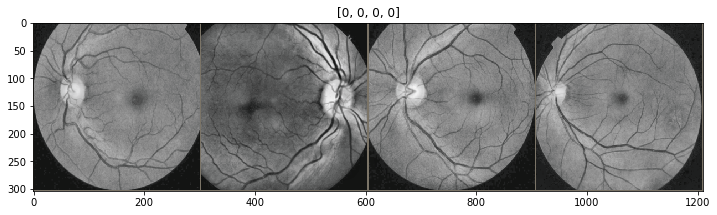

In [261]:

example_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)


class_names = [0,1,2,3,4]
# Get a batch of training data
inputs, classes = next(iter(example_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

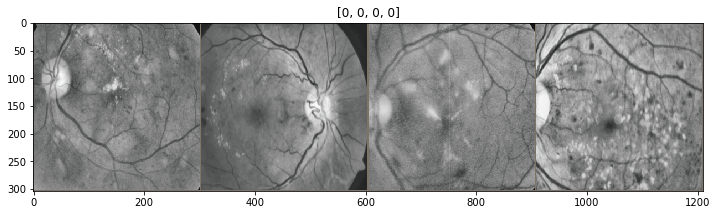

In [263]:
example_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=4)

class_names = [0,1,2,3,4]
# Get a batch of training data
inputs, classes = next(iter(example_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Define Model

In [8]:
device = torch.device("cuda:0")
torch.cuda.is_available()


model =  EfficientNet.from_pretrained('efficientnet-b3') 
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model.cuda()


# model = models.resnet101(pretrained=True)
# in_features = model.fc.in_features
# model.fc = nn.Linear(in_features, num_classes)
# model.cuda()






Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

### Loss function and optimizor

In [9]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

### Training

In [10]:
best_avg_loss = 100.0
n_epochs      = 15

for epoch in range(n_epochs):
    
    print('lr:', scheduler.get_lr()[0]) 
    start_time   = time.time()
    avg_loss     = train_model(epoch)
    avg_val_loss = test_model()
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
    
    if avg_val_loss < best_avg_loss:
        best_avg_loss = avg_val_loss
        torch.save(model.state_dict(), model_name)
    
    scheduler.step()

lr: 0.001
Epoch 1/15 	 loss=0.7259 	 val_loss=0.5593 	 time=163.26s
lr: 0.001
Epoch 2/15 	 loss=0.4398 	 val_loss=0.4659 	 time=162.64s
lr: 0.001
Epoch 3/15 	 loss=0.4416 	 val_loss=0.4729 	 time=163.27s
lr: 0.001
Epoch 4/15 	 loss=0.4050 	 val_loss=0.3069 	 time=163.28s
lr: 0.001
Epoch 5/15 	 loss=0.3728 	 val_loss=0.3656 	 time=163.34s
lr: 1e-05
Epoch 6/15 	 loss=0.3063 	 val_loss=0.2795 	 time=163.45s
lr: 0.0001
Epoch 7/15 	 loss=0.2630 	 val_loss=0.2874 	 time=163.03s
lr: 0.0001
Epoch 8/15 	 loss=0.2608 	 val_loss=0.2562 	 time=163.39s
lr: 0.0001
Epoch 9/15 	 loss=0.2419 	 val_loss=0.2777 	 time=163.45s
lr: 0.0001
Epoch 10/15 	 loss=0.2317 	 val_loss=0.2837 	 time=163.33s
lr: 1.0000000000000002e-06
Epoch 11/15 	 loss=0.2311 	 val_loss=0.2606 	 time=163.66s
lr: 1e-05
Epoch 12/15 	 loss=0.2218 	 val_loss=0.2524 	 time=163.97s
lr: 1e-05
Epoch 13/15 	 loss=0.2184 	 val_loss=0.2544 	 time=163.57s
lr: 1e-05
Epoch 14/15 	 loss=0.2196 	 val_loss=0.2646 	 time=163.34s
lr: 1e-05
Epoch 15/15 

In [11]:
# effi B0  Epoch 15/20 	 loss=0.2432 	 val_loss=0.2899 	 time=120.21s
# effi B0 greenonly gamma correction   Epoch 8/20 	 loss=0.2640 	 val_loss=0.2800 	 time=127.31s
# effi B3 greenonly gamma correction rotaion Epoch 15/20 	 loss=0.1973 	 val_loss=0.2289 	 time=126.98s  "model/b3_clahe_g_gamma.bin"
# effi B3 greenonly gamma correction rotaion AMP Epoch 19/20 	 loss=0.1855 	 val_loss=0.2305 	 time=163.35s

## Validation Kappa Score

In [12]:
from sklearn import metrics


val_pred = np.zeros((len(val_df), 1))


for i, data in tqdm(enumerate(val_loader)):
    images, labels = data
    images = images.to(device, dtype=torch.float)
    outputs = model(images) 
    val_pred[i * BS:(i + 1) * BS] += outputs.detach().cpu().squeeze().numpy().reshape(-1, 1)


coef = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(val_pred):
    if pred < coef[0]:
        val_pred[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        val_pred[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        val_pred[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        val_pred[i] = 3
    else:
        val_pred[i] = 4
        
val_df['pred'] = val_pred

metrics.cohen_kappa_score(val_df['diagnosis'], val_df['pred'], weights='quadratic')

/home/qile/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.9069680800952373

In [13]:
val_df

,id_code,diagnosis,pred
0,1b32e1d775ea,4,4.0
1,de16416220de,4,3.0
2,0af296d2f04a,2,2.0
3,75a071608ea6,0,0.0
4,d83c3efade75,2,2.0
5,1a90fad9ffa2,4,3.0
6,02cd34a85b24,0,0.0
7,87b671c6d4c5,0,0.0
8,a5bb85afc6e8,0,0.0
9,962c0fc85e13,0,0.0
